# EDA

## Preparation

### Import Necessary Library

In [ ]:
#Importing Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.patches as mpatches
import sys
import warnings
import os
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

### Install Necessary Tools

In [ ]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# converts midi files to wav files into order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('installing musescore...')
!apt install musescore3 > /dev/null

print('done!')

installing lilypond...
Extracting templates from packages: 100%
installing fluidsynth...
Extracting templates from packages: 100%
installing musescore...


done!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Gathering

In [ ]:
#Loading the list of chopin's midi files as stream
filepath = "/content/drive/MyDrive/ClassicalMusic/chopin/"

#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi_ut = converter.parse(tr)
        midi = midi_ut.stripTies()
        all_midis.append(midi)


In [ ]:
def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(str(filename) + '.wav'))

def download(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  return (str(filename) + '.wav')

Defining function for production of audio and sheet music.

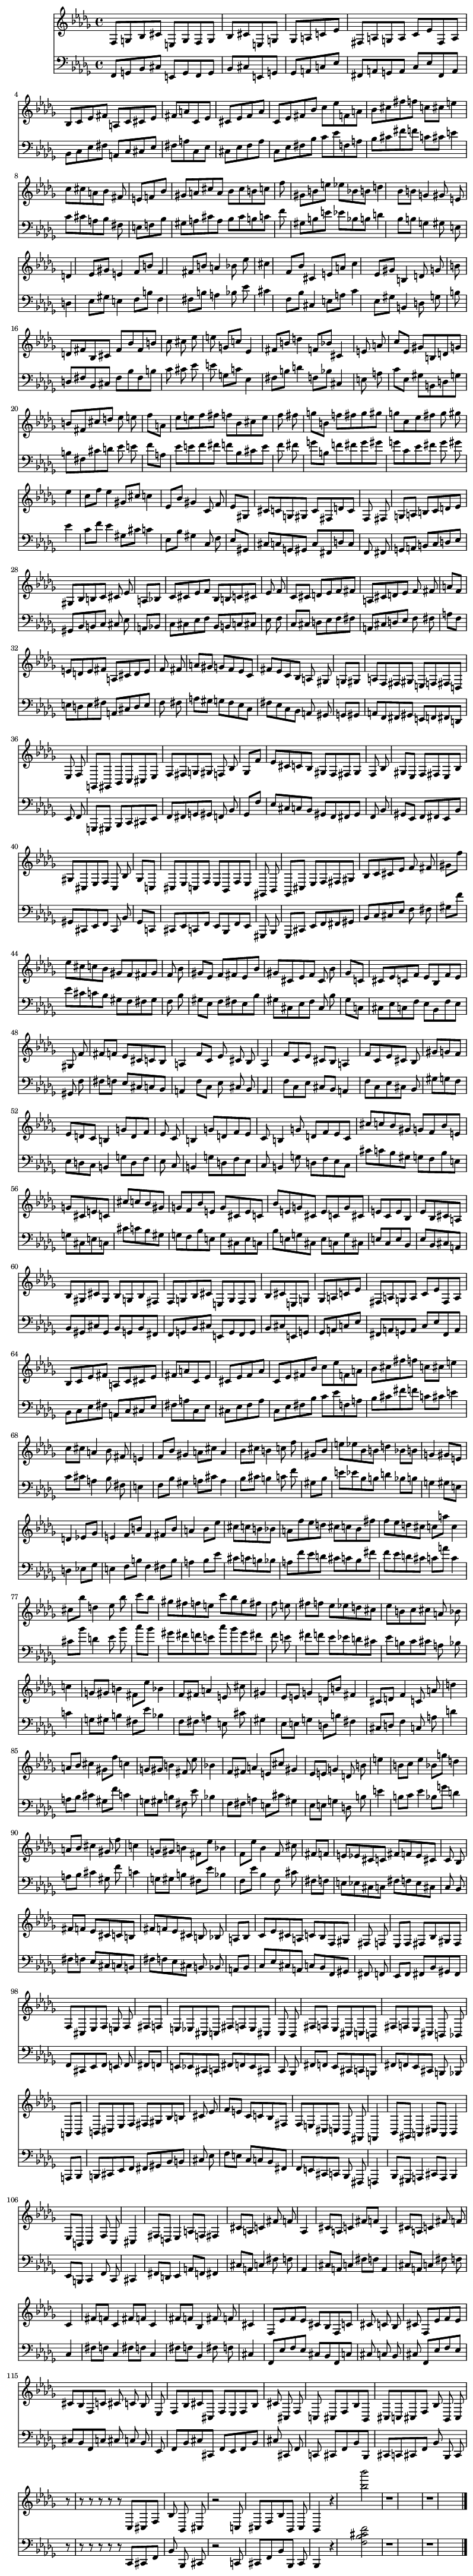

In [ ]:
show(all_midis[1])

Sheet music one of the chopin's composed music.

In [ ]:
play(all_midis[1])

Audio music one of the chopin's composed music.

## Data Preprocessing

### Clef splitting

In [ ]:
def split_part(midis):
  all_midis_parts = []

  for midi in midis:
    for i in range(len(midi.parts)):
      all_midis_parts.append(midi.parts[i])

  return all_midis_parts

In [ ]:
all_midi_split = split_part(all_midis)

In [ ]:
len(all_midi_split)

100

Each of the music composed of two part which is also means two clef. There are total of 50 midi file, therefore, there are 100 parts in total.

In [ ]:
def split_clef(midis_parts):
  treble_clef_midi = []
  bass_clef_midi = []

  for midi in midis_parts:
    for element in midi.flat:

      clef_name = None

      if isinstance(element, music21.clef.Clef):
        clef_name = str(element.name)

        if clef_name  == 'treble':
          treble_clef_midi.append(midi)

        elif clef_name == 'bass':
          bass_clef_midi.append(midi)

  return treble_clef_midi, bass_clef_midi


Each of the part was looked for their clef property, the part with same clef property will be group together, i.e. part with treble clef property belongs to treble clef while part with bass clef property belongs to bass clef.  

In [ ]:
treble_midis, bass_midis = split_clef(all_midi_split)

In [ ]:
treble_midis

[<music21.stream.Part 0x78d7f3b2e020>,
 <music21.stream.Part 0x78d7f2e5a800>,
 <music21.stream.Part 0x78d7f2bc7640>,
 <music21.stream.Part 0x78d7f057ab60>,
 <music21.stream.Part 0x78d7ed2a0c40>,
 <music21.stream.Part 0x78d7ebf90190>,
 <music21.stream.Part 0x78d7e9dd1780>,
 <music21.stream.Part 0x78d7e6bd90c0>,
 <music21.stream.Part 0x78d7e69b85b0>,
 <music21.stream.Part 0x78d7e592f0d0>,
 <music21.stream.Part 0x78d7e34a07f0>,
 <music21.stream.Part 0x78d7e34a06d0>,
 <music21.stream.Part 0x78d7e0e5ce50>,
 <music21.stream.Part 0x78d7dfdaa620>,
 <music21.stream.Part 0x78d7de90d2d0>,
 <music21.stream.Part 0x78d7de2d50f0>,
 <music21.stream.Part 0x78d7dd869540>,
 <music21.stream.Part 0x78d7df0eb850>,
 <music21.stream.Part 0x78d7da413dc0>,
 <music21.stream.Part 0x78d7da393850>,
 <music21.stream.Part 0x78d7dd3ed8d0>,
 <music21.stream.Part 0x78d7d7410a30>,
 <music21.stream.Part 0x78d7d59b6a70>,
 <music21.stream.Part 0x78d7d57e27d0>,
 <music21.stream.Part 0x78d7d7743850>,
 <music21.stream.Part 0x7

In [ ]:
bass_midis

[<music21.stream.Part 0x78d81dbcd660>,
 <music21.stream.Part 0x78d7f2e58820>,
 <music21.stream.Part 0x78d7f2bc4be0>,
 <music21.stream.Part 0x78d7f057a5c0>,
 <music21.stream.Part 0x78d7ed2a0c10>,
 <music21.stream.Part 0x78d7ed198760>,
 <music21.stream.Part 0x78d7ec3fe380>,
 <music21.stream.Part 0x78d7ecb4fe50>,
 <music21.stream.Part 0x78d7e6bd8f70>,
 <music21.stream.Part 0x78d7e69b8970>,
 <music21.stream.Part 0x78d7e592eda0>,
 <music21.stream.Part 0x78d7e30d7250>,
 <music21.stream.Part 0x78d7e0e5cee0>,
 <music21.stream.Part 0x78d7dfdaa4d0>,
 <music21.stream.Part 0x78d7de90d2a0>,
 <music21.stream.Part 0x78d7de2d5750>,
 <music21.stream.Part 0x78d7dd8699f0>,
 <music21.stream.Part 0x78d7df134520>,
 <music21.stream.Part 0x78d7d94e0760>,
 <music21.stream.Part 0x78d7dd3ecdf0>,
 <music21.stream.Part 0x78d7d6faff10>,
 <music21.stream.Part 0x78d7d59b6dd0>,
 <music21.stream.Part 0x78d7d57e2020>,
 <music21.stream.Part 0x78d7d7743af0>,
 <music21.stream.Part 0x78d7d56bff40>,
 <music21.stream.Part 0x7

### Music Element Extraction

In [ ]:
def extract_notes_all(midi_clef):

  notes = []
  durations = []
  sequence_num = []

  for midi_part in midi_clef:
    for element in midi_part.flat:
      note_name = None
      duration_name  = None

      if isinstance(element, music21.chord.Chord):
        note_name = []
        for i in element.pitches:
          note_name.append(i.frequency)
        duration_name = element.duration.type

      elif isinstance(element, music21.note.Rest):
        note_name = 0
        duration_name = element.duration.type

      elif isinstance(element, music21.note.Note):
        note_name = str(element.pitch.frequency)
        duration_name = element.duration.type

      if note_name and duration_name:
        if type(note_name) == list:
          for i in note_name:
            notes.append(i)
            durations.append(duration_name)
        else:
          notes.append(note_name)
          durations.append(duration_name)

  return notes, durations

The music element such as notes, chords and durations will be extracted for each clef. Noted that, each music elements of treble and bass clef are remains separated. The notes and chords are grouped together under the same feature while durations itself become another feature.

In [ ]:
bass_midis_element = extract_notes_all(bass_midis)
treble_midis_element = extract_notes_all(treble_midis)

In [ ]:
bass_midis_element

(['92.4986056779085',
  '174.61411571650183',
  '207.65234878997245',
  '184.9972113558171',
  '233.08188075904488',
  '138.59131548843592',
  '92.4986056779085',
  '174.61411571650183',
  '207.65234878997245',
  '184.9972113558171',
  '233.08188075904488',
  '138.59131548843592',
  '92.4986056779085',
  '174.61411571650183',
  '207.65234878997245',
  '184.9972113558171',
  '233.08188075904488',
  '138.59131548843592',
  '69.29565774421793',
  '195.99771799087452',
  '233.08188075904488',
  '207.65234878997245',
  '246.94165062806198',
  '138.59131548843592',
  '92.4986056779085',
  '174.61411571650183',
  '207.65234878997245',
  '184.9972113558171',
  '233.08188075904488',
  '138.59131548843592',
  '92.4986056779085',
  '174.61411571650183',
  '207.65234878997245',
  '184.9972113558171',
  '233.08188075904488',
  '138.59131548843592',
  '92.4986056779085',
  '174.61411571650183',
  '207.65234878997245',
  '184.9972113558171',
  '233.08188075904488',
  '138.59131548843592',
  '69.29565

In [ ]:
len(bass_midis_element[0])

41883

In [ ]:
len(bass_midis_element[1])

41883

In [ ]:
treble_midis_element

([277.182630976872,
  369.99442271163434,
  466.1637615180899,
  369.99442271163434,
  277.182630976872,
  466.1637615180899,
  277.182630976872,
  466.1637615180899,
  369.99442271163434,
  '349.2282314330038',
  '493.8833012561241',
  '415.3046975799451',
  369.99442271163434,
  466.1637615180899,
  277.182630976872,
  '277.182630976872',
  369.99442271163434,
  466.1637615180899,
  466.1637615180899,
  369.99442271163434,
  '277.182630976872',
  466.1637615180899,
  369.99442271163434,
  493.8833012561241,
  415.3046975799451,
  466.1637615180899,
  369.99442271163434,
  349.2282314330038,
  415.3046975799451,
  466.1637615180899,
  369.99442271163434,
  '349.2282314330038',
  554.3652619537443,
  466.1637615180899,
  493.8833012561241,
  415.3046975799451,
  415.3046975799451,
  277.182630976872,
  277.182630976872,
  369.99442271163434,
  466.1637615180899,
  466.1637615180899,
  277.182630976872,
  554.3652619537443,
  466.1637615180899,
  739.988845423269,
  369.99442271163434,


In [ ]:
len(treble_midis_element[0])

43795

In [ ]:
len(treble_midis_element[1])

43795

### Dataframe Construction

There are total two dataframe constructed for each clef. Each dataframe consist of two features. The first feature named as music_element where it consist of notes and chords while second feature named as duration where it consist of duration only.

In [ ]:
bass_df = pd.DataFrame(bass_midis_element).T
bass_df.columns = ['music_element', 'duration']
bass_df['music_element'] = bass_df['music_element'].astype('float')

In [ ]:
bass_df

music_element duration
0          92.498606   eighth
1         174.614116   eighth
2         207.652349   eighth
3         184.997211   eighth
4         233.081881   eighth
...              ...      ...
41878     184.997211  quarter
41879     277.182631  quarter
41880     466.163762  quarter
41881      46.249303     half
41882      92.498606     half

[41883 rows x 2 columns]

In [ ]:
treble_df = pd.DataFrame(treble_midis_element).T
treble_df.columns = ['music_element', 'duration']
treble_df['music_element'] = treble_df['music_element'].astype('float')

In [ ]:
treble_df

music_element duration
0         277.182631     half
1         369.994423     half
2         466.163762     half
3         369.994423     half
4         277.182631     half
...              ...      ...
43790    1864.655046  quarter
43791    1479.977691  quarter
43792    1108.730524  quarter
43793     932.327523  quarter
43794     184.997211     half

[43795 rows x 2 columns]

# Univariate Analysis

## Bass Clef

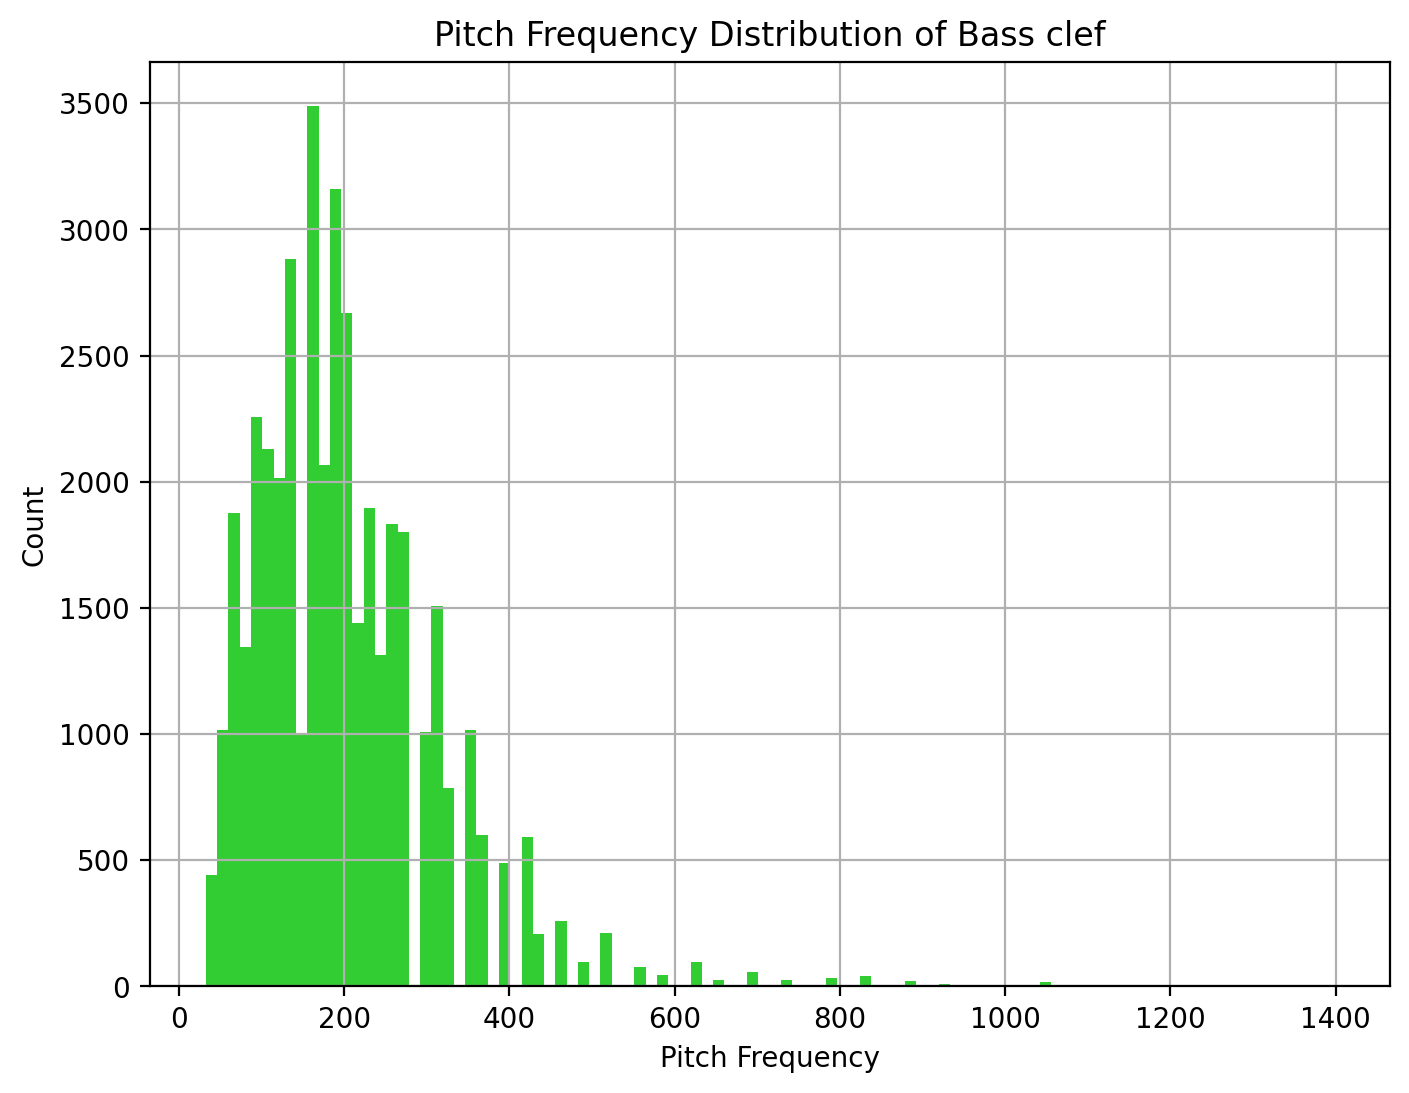

In [ ]:
bass_df.hist(bins=100, figsize=(8,6), color = "limegreen")
plt.xlabel('Pitch Frequency')
plt.ylabel("Count")
plt.title("Pitch Frequency Distribution of Bass clef")
plt.show()

The distribution of pitch frequency is positively skewed with the modes around 160 hertz. Majority of the chords and notes used is in the frequencies of 50
 to 300 hertz. While chords and notes with frequencies around 500 hertz and above can be seen as minority chords and notes used in the Chopin composed music.

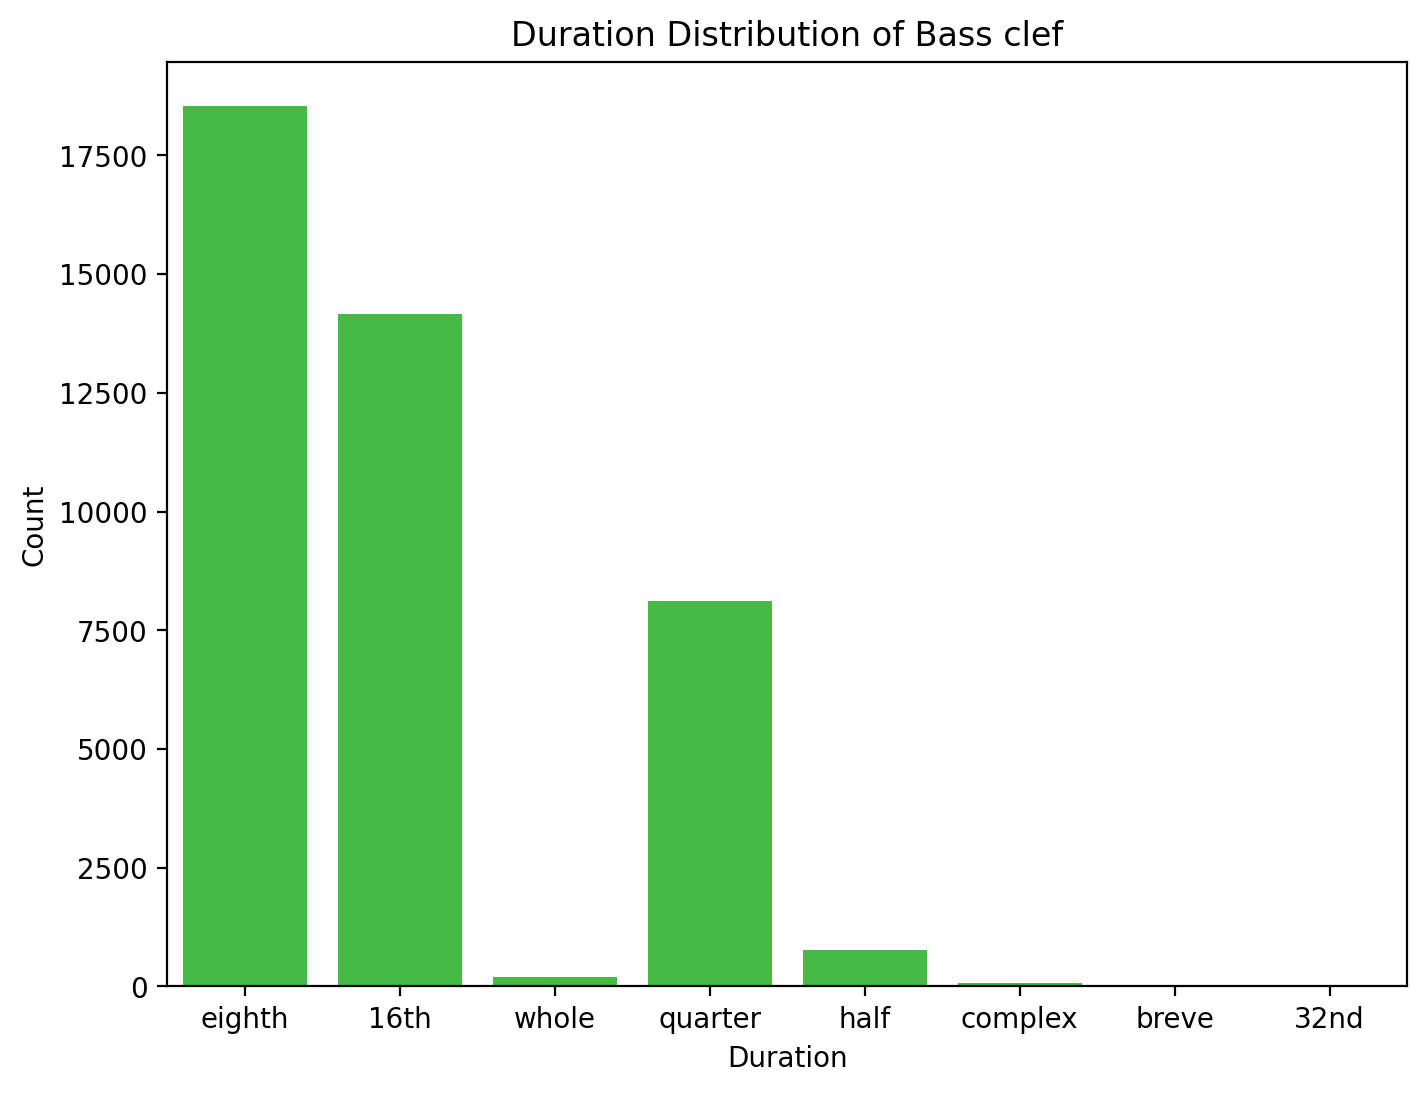

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(bass_df, x="duration",  color = "limegreen")
plt.xlabel('Duration')
plt.ylabel("Count")
plt.title("Duration Distribution of Bass clef")
plt.show()


Majority of the durations used was 8th notes with around 17500 counts followed by 16th note with around 14000 counts. The quarter notes is in the third position with around 7500 count. Other than the mentioned durations which are whole note, half note, complex note, breve note and 32nd note are the minority durations in the Chopin compoased music.

## Treble Clef

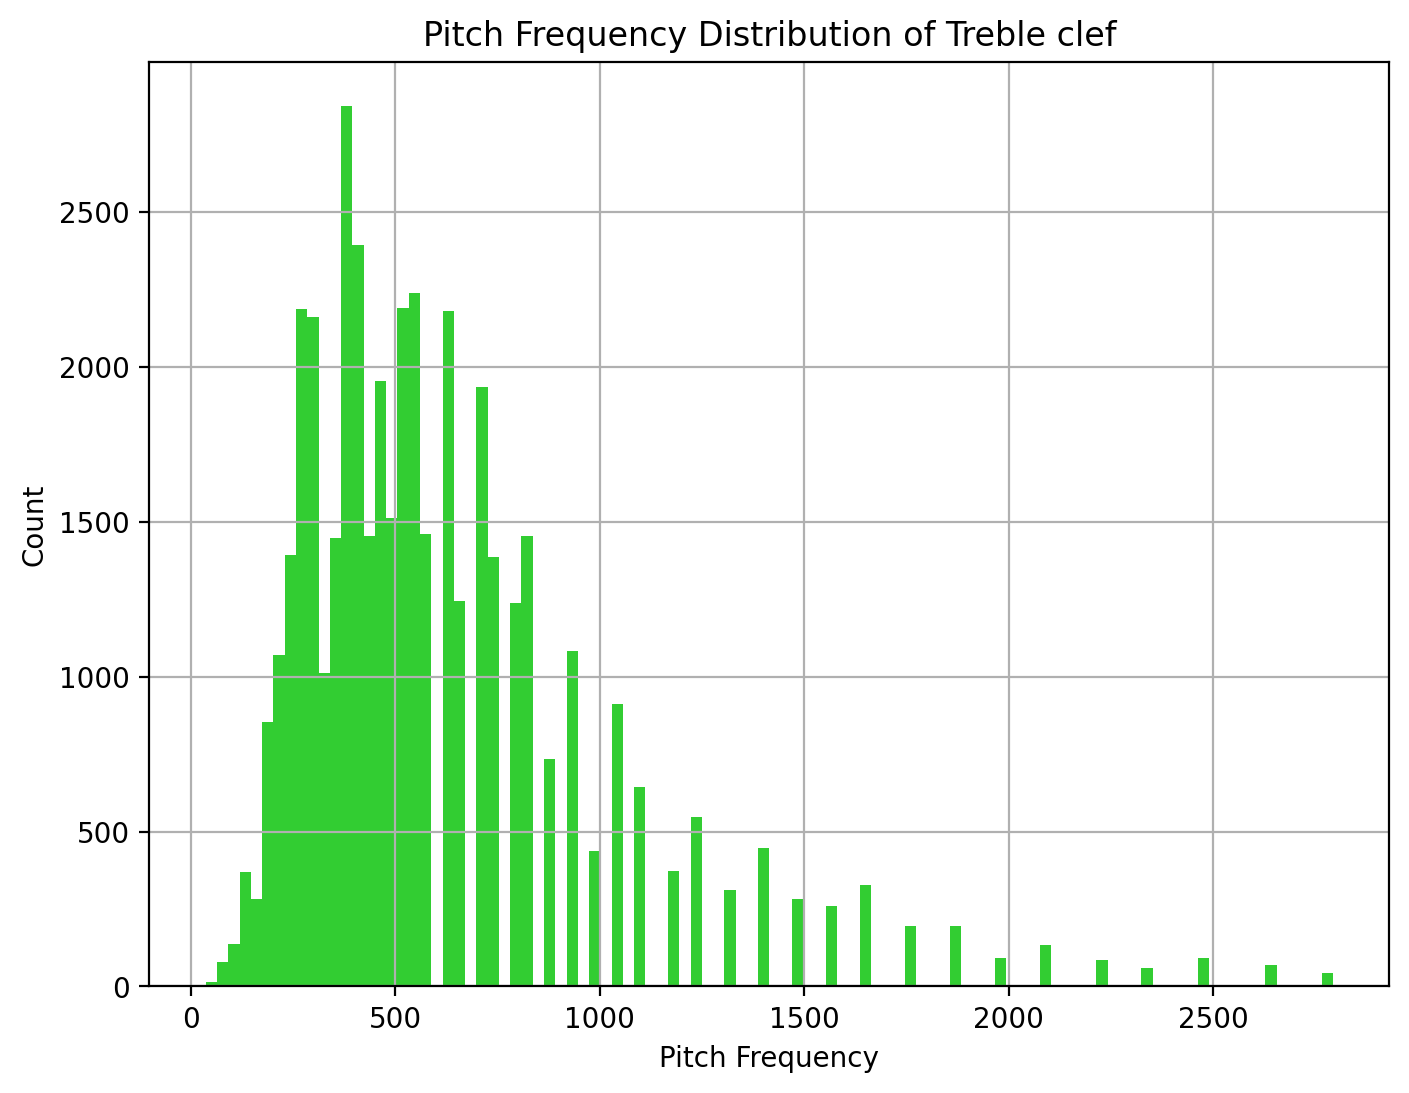

In [ ]:
treble_df.hist(bins=100, figsize=(8,6),  color = "limegreen")
plt.xlabel('Pitch Frequency')
plt.ylabel("Count")
plt.title("Pitch Frequency Distribution of Treble clef")
plt.show()

The distribution of pitch frequency is positively skewed with the modes around 350 hertz. Majority of the chords and notes used is in the frequencies of 200
 to 1300 hertz. While chords and notes with frequencies around 1500 hertz and above can be seen as minority chords and notes used in the Chopin composed music.

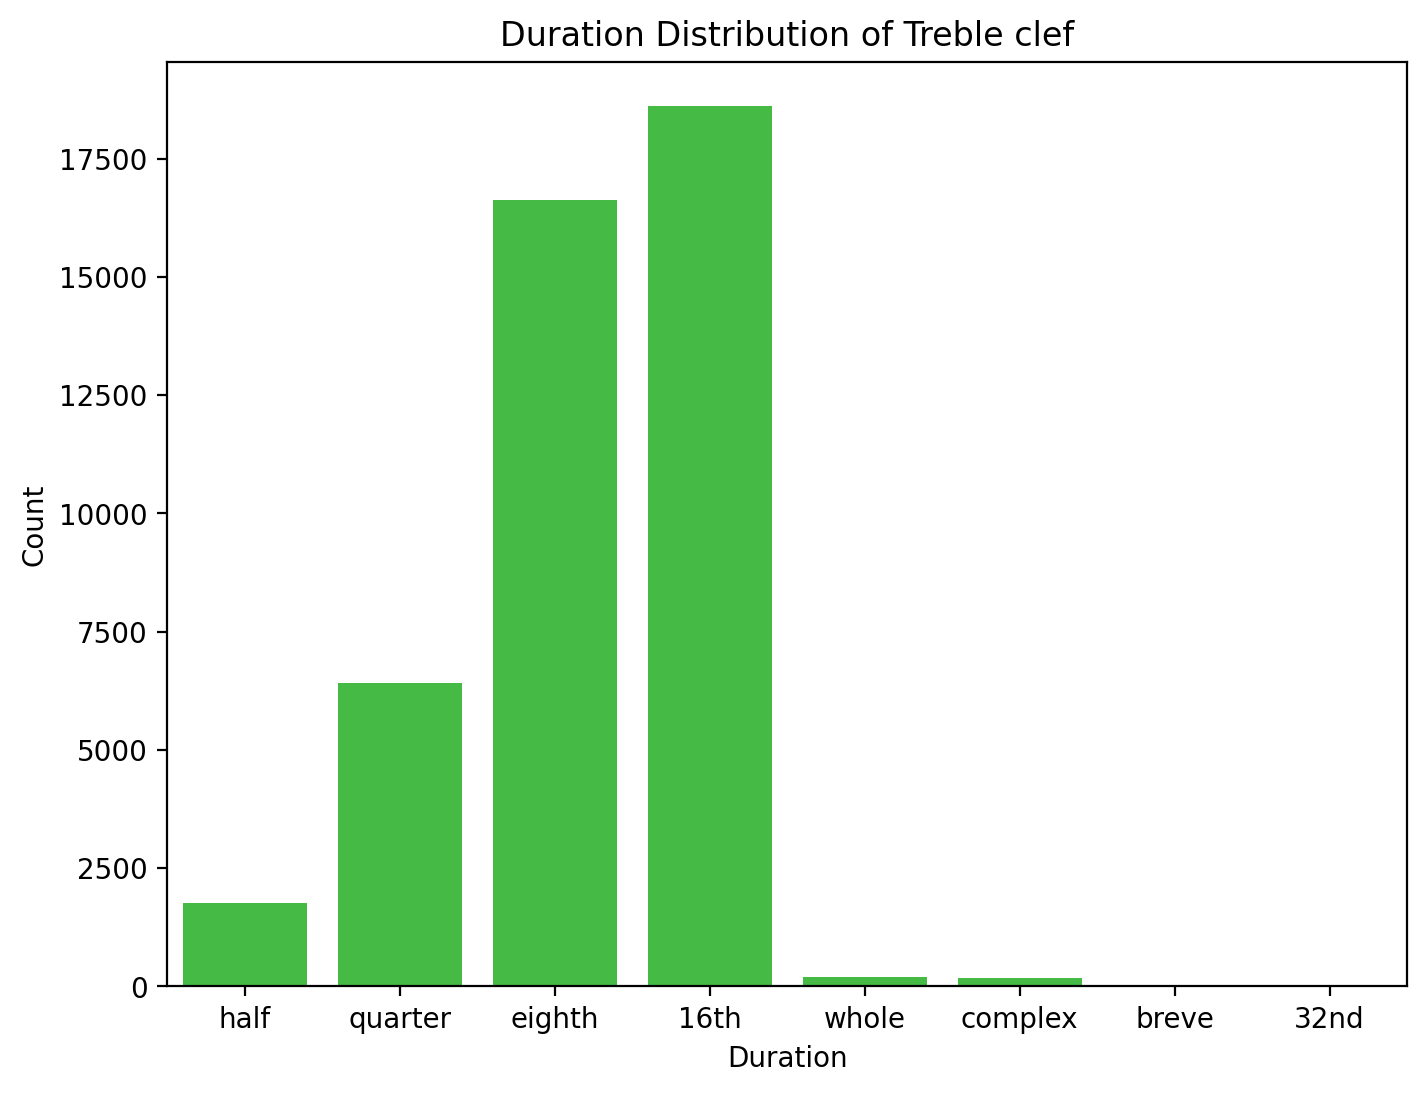

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(treble_df, x="duration", color = "limegreen")
plt.xlabel('Duration')
plt.ylabel("Count")
plt.title("Duration Distribution of Treble clef")
plt.show()

Majority of the durations used was 16th notes followed by 8th note. The quarter notes is in the third position with around 6500 counts. Other than the mentioned durations which are whole note, half note, complex note, breve note and 32nd note are the minority durations in the Chopin compoased music.

## Both Clef

Combine both dataframe into one dataframe.

In [ ]:
all_data = [bass_df, treble_df]

df = pd.concat(all_data)

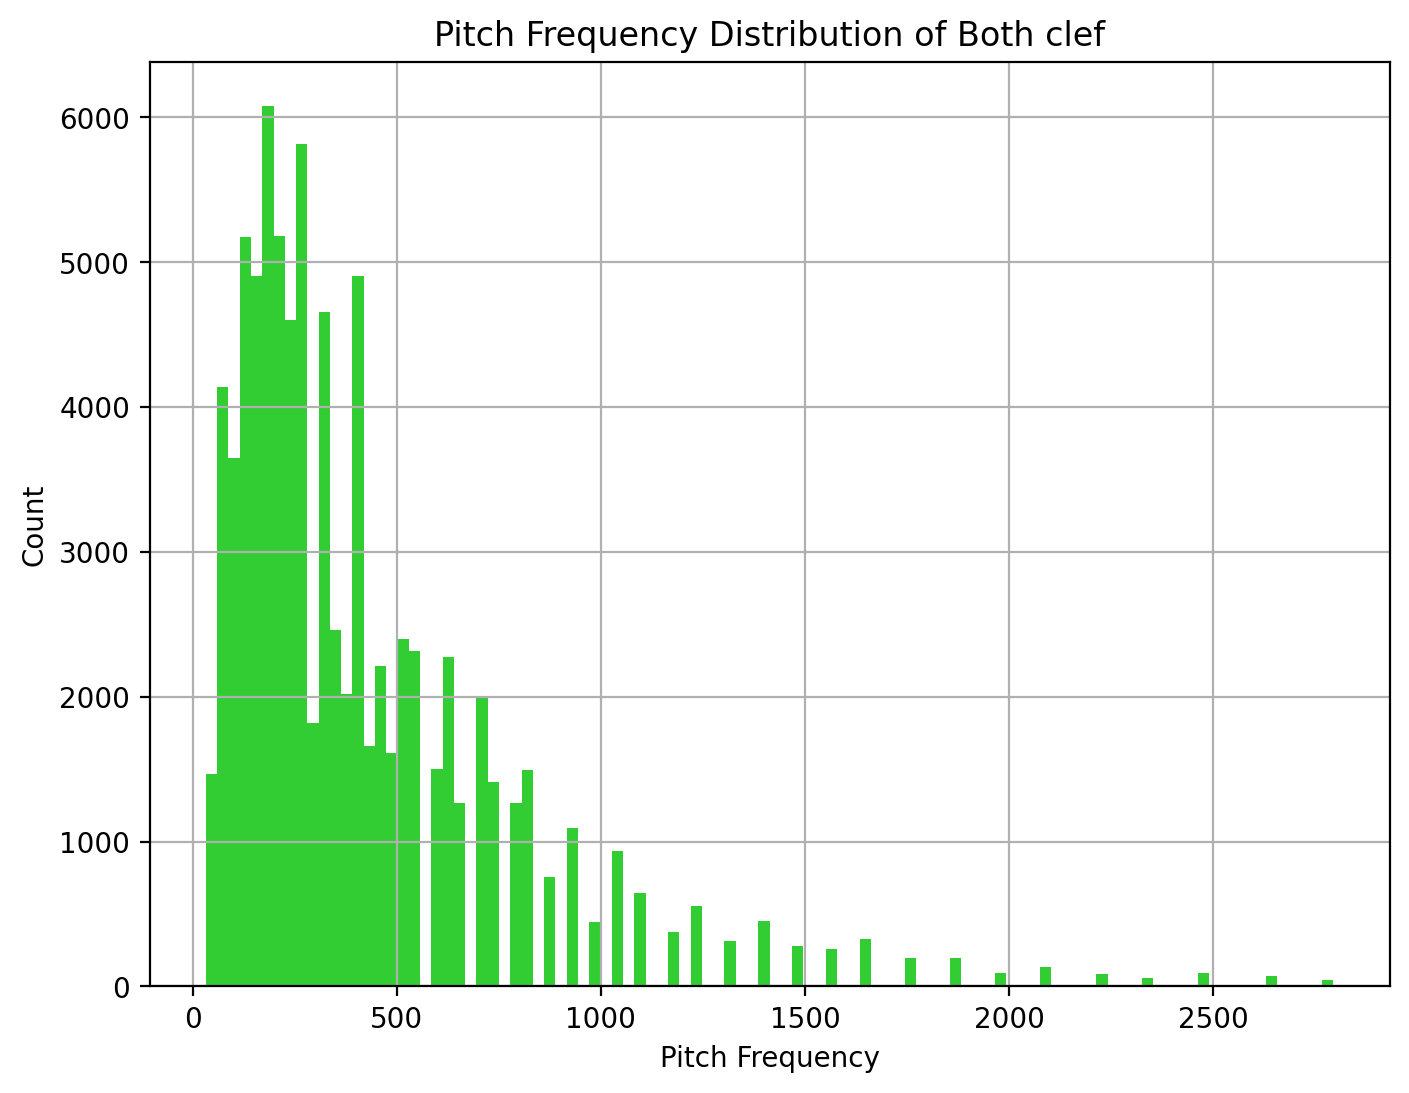

In [ ]:
df.hist(bins=100, figsize=(8,6),  color = "limegreen")
plt.xlabel('Pitch Frequency')
plt.ylabel("Count")
plt.title("Pitch Frequency Distribution of Both clef")
plt.show()

The distribution of pitch frequency is positively skewed with the modes around 250 hertz. Majority of the chords and notes used is in the frequencies of 50
 to 750 hertz. While chords and notes with frequencies around 1000 hertz and above can be seen as minority chords and notes in the Chopin composed music.

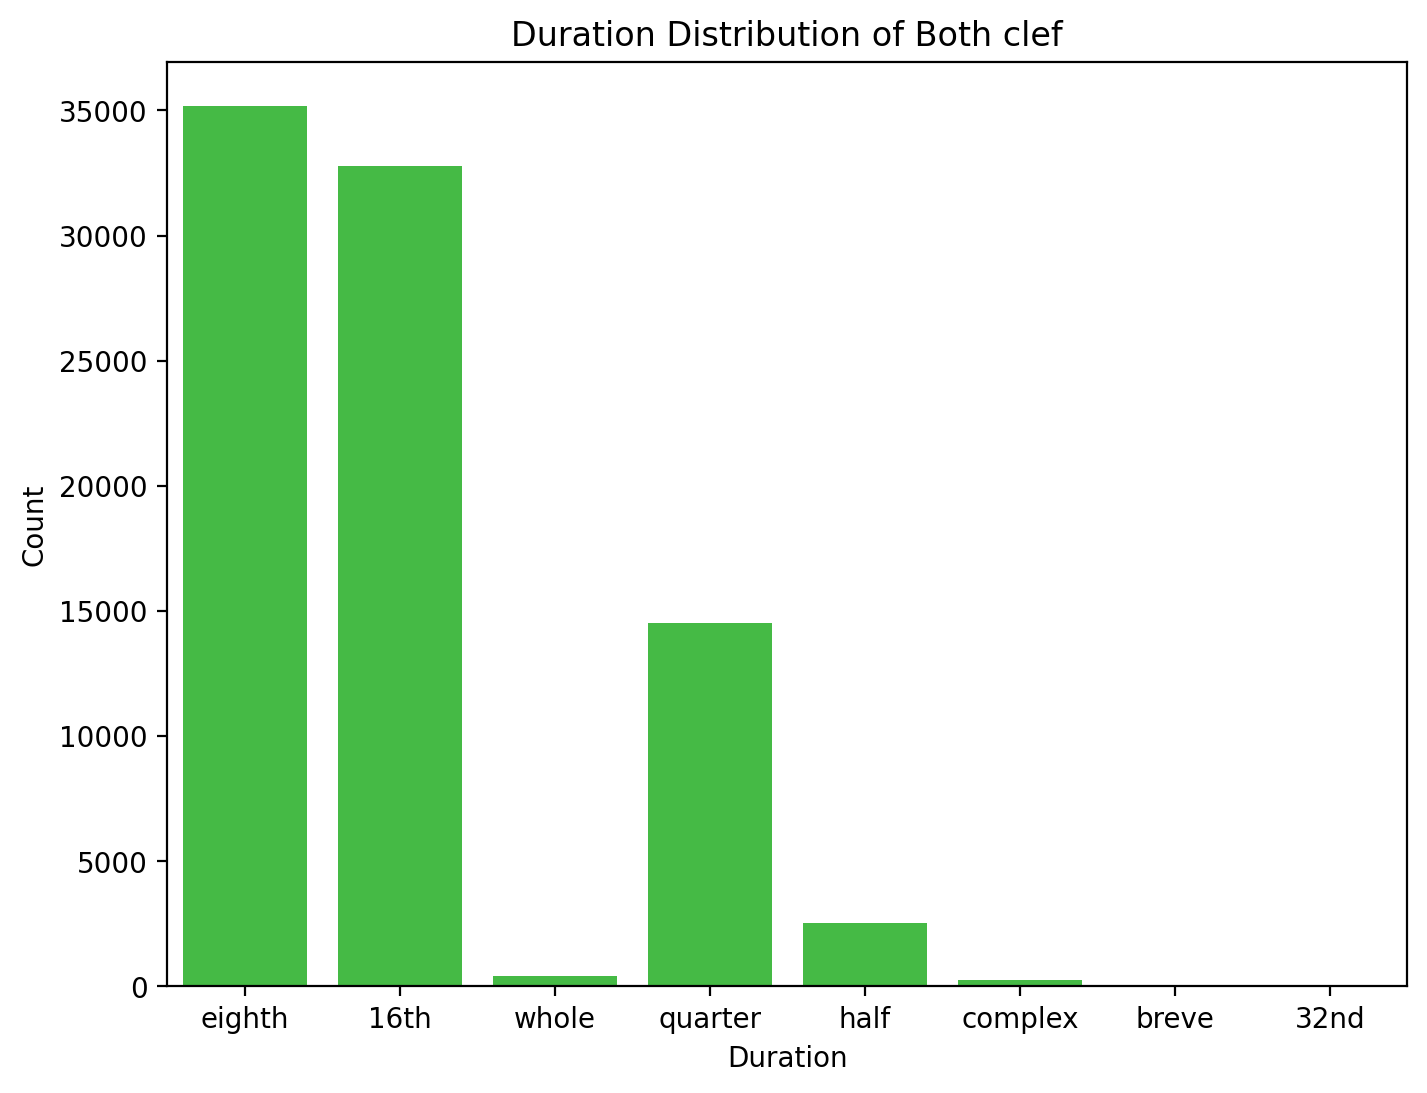

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(df, x="duration",  color = "limegreen")
plt.xlabel('Duration')
plt.ylabel("Count")
plt.title("Duration Distribution of Both clef")
plt.show()


Majority of the durations used was 8th notes with 35000 counts followed by 16th note with around 32500 counts. The quarter notes is in the third position with 15000 counts. Other than the mentioned durations which are whole note, half note, complex note, breve note and 32nd note are the minority durations in the Chopin compoased music.

# Multivariate Analysis

## Bass Clef

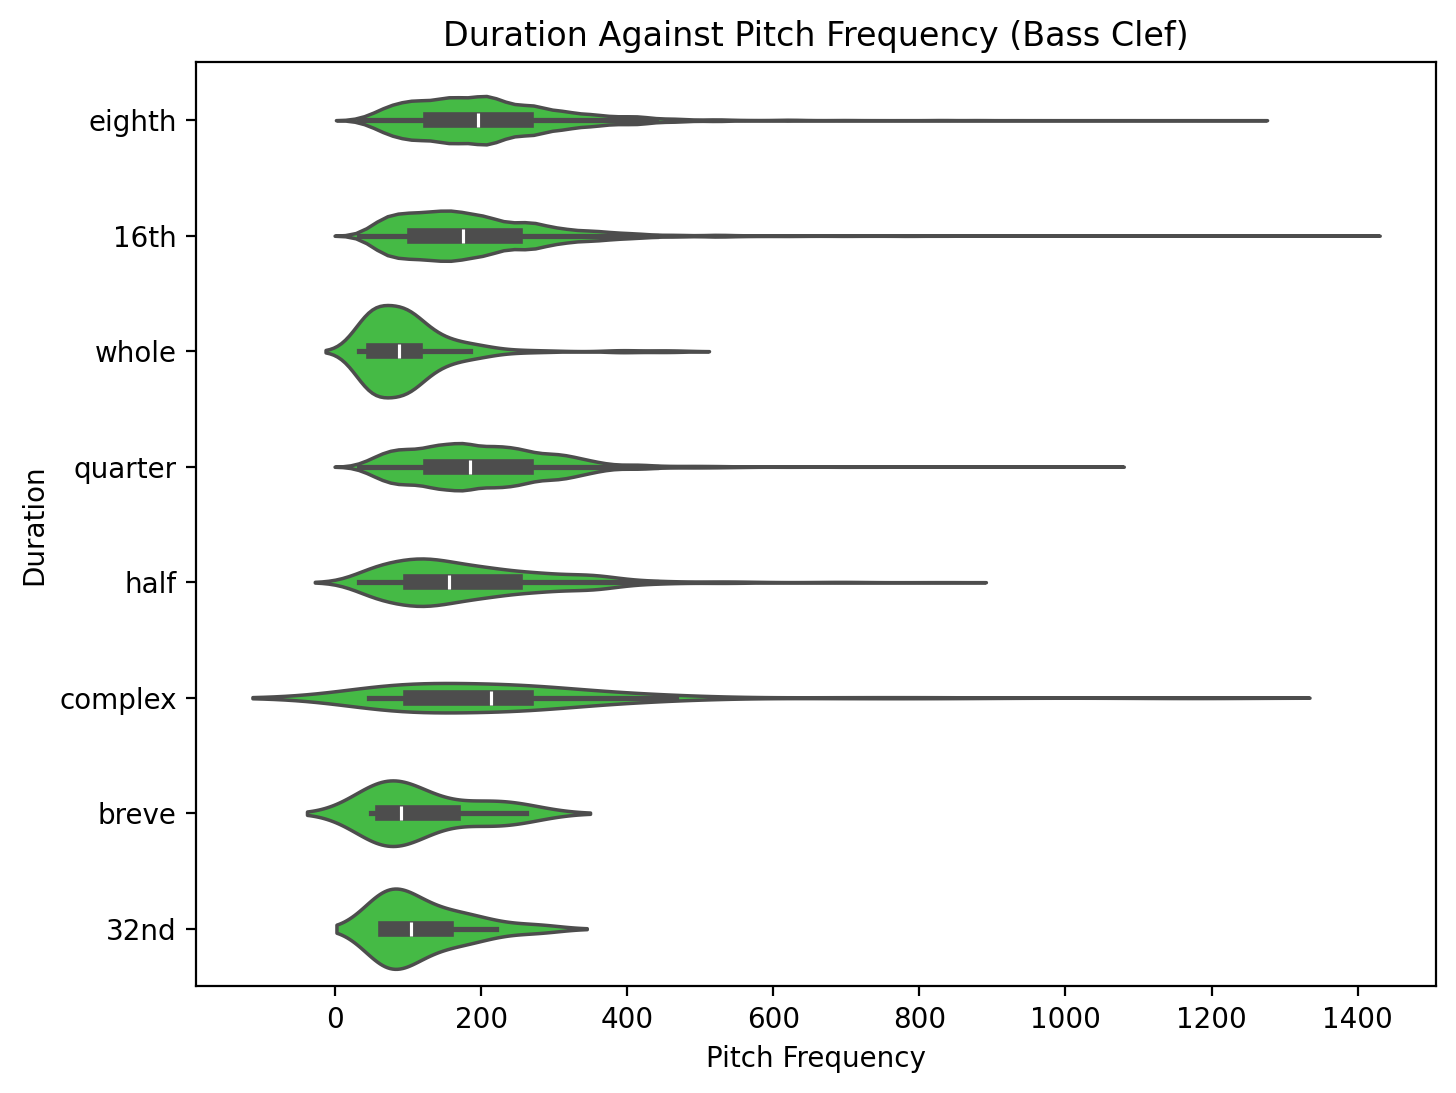

In [ ]:
plt.figure(figsize=(8, 6))
sns.violinplot(x ='music_element', y ='duration', data = bass_df,  color = "limegreen")
plt.xlabel('Pitch Frequency')
plt.ylabel('Duration')
plt.title("Duration Against Pitch Frequency (Bass Clef)")
plt.show()

The 8th note, 16th note and quarter note have almost similar shape of distribution which is almost symmetric. Majority of the notes are in the range of 30 to 400 hertz. The range of 8th note distribution is around 20 to 1300 hertz while the range of 16th note distribution is around 20 to 1400 hertz. Half note has similar distribution of majority of the notes but postively skewed with the mode around 100 hertz. The whole note has a mode around 80 hertz with majority of the notes is in the range of 20 to 200 hertz. The complex note has the range of distribution of 0 to 1400 hertz with majority of the notes is in the range of 0 to 400 hertz. Both breve note and 32nd note has almost the same shape of distribution with almost same modes around 100 hertz. Also, both have the same range of distribtion which from 0 to around 360 hertz.

## Treble Clef

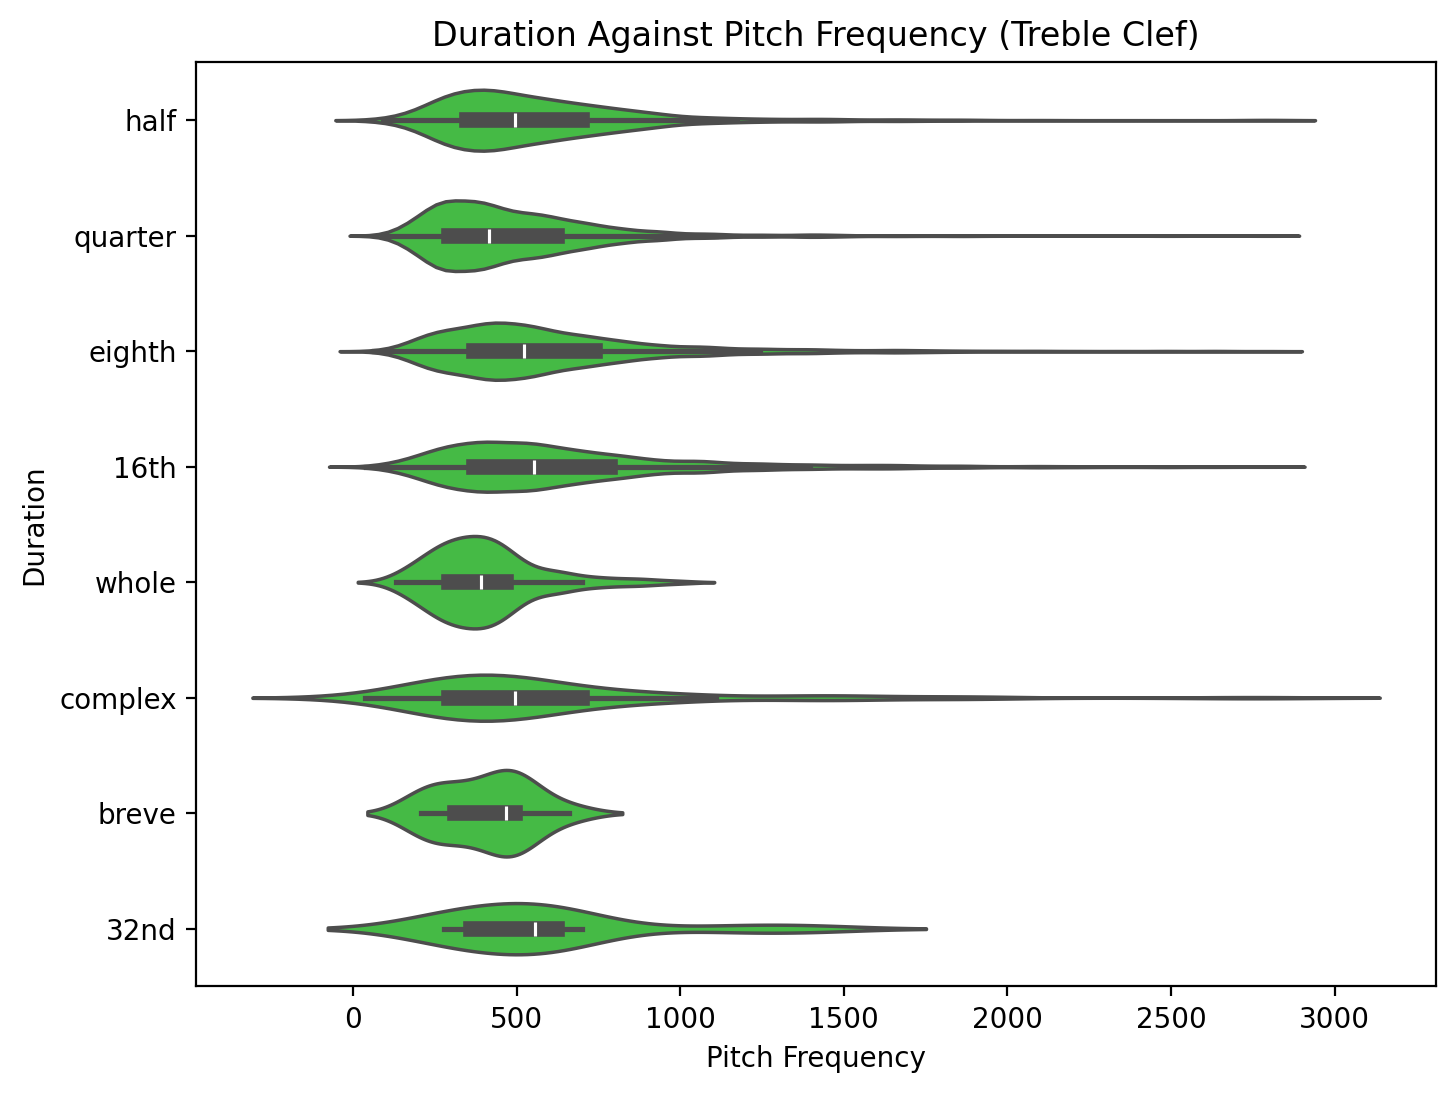

In [ ]:
plt.figure(figsize=(8, 6))
sns.violinplot(x ='music_element', y ='duration', data = treble_df,  color = "limegreen")
plt.xlabel('Pitch Frequency')
plt.ylabel('Duration')
plt.title("Duration Against Pitch Frequency (Treble Clef)")
plt.show()

The half note, quarter note, 8th note and 16th note have almost similar shape of distribution which is slight positively skewed with almost similar range where most notes are in the range of 200 to 1000 hertz with the distribution range of 200 to 2900 hertz. The whole note has a mode around 450 hertz with distribution range of 150 to 1000 hertz. The complex note has the longest range of distribution of 0 to 3000 hertz. The breve note distribution is the only negatively skewed in the treble clef dsitribution, the breve note distribution has mode around 500 hertz with the range of 200 to 800 hertz. The 32nd note distribution has mode around 500 hertz with the range of 0 to 1750 hertz with the majority of the notes lies in the range of 200 to 800 hertz.

## Both Clef

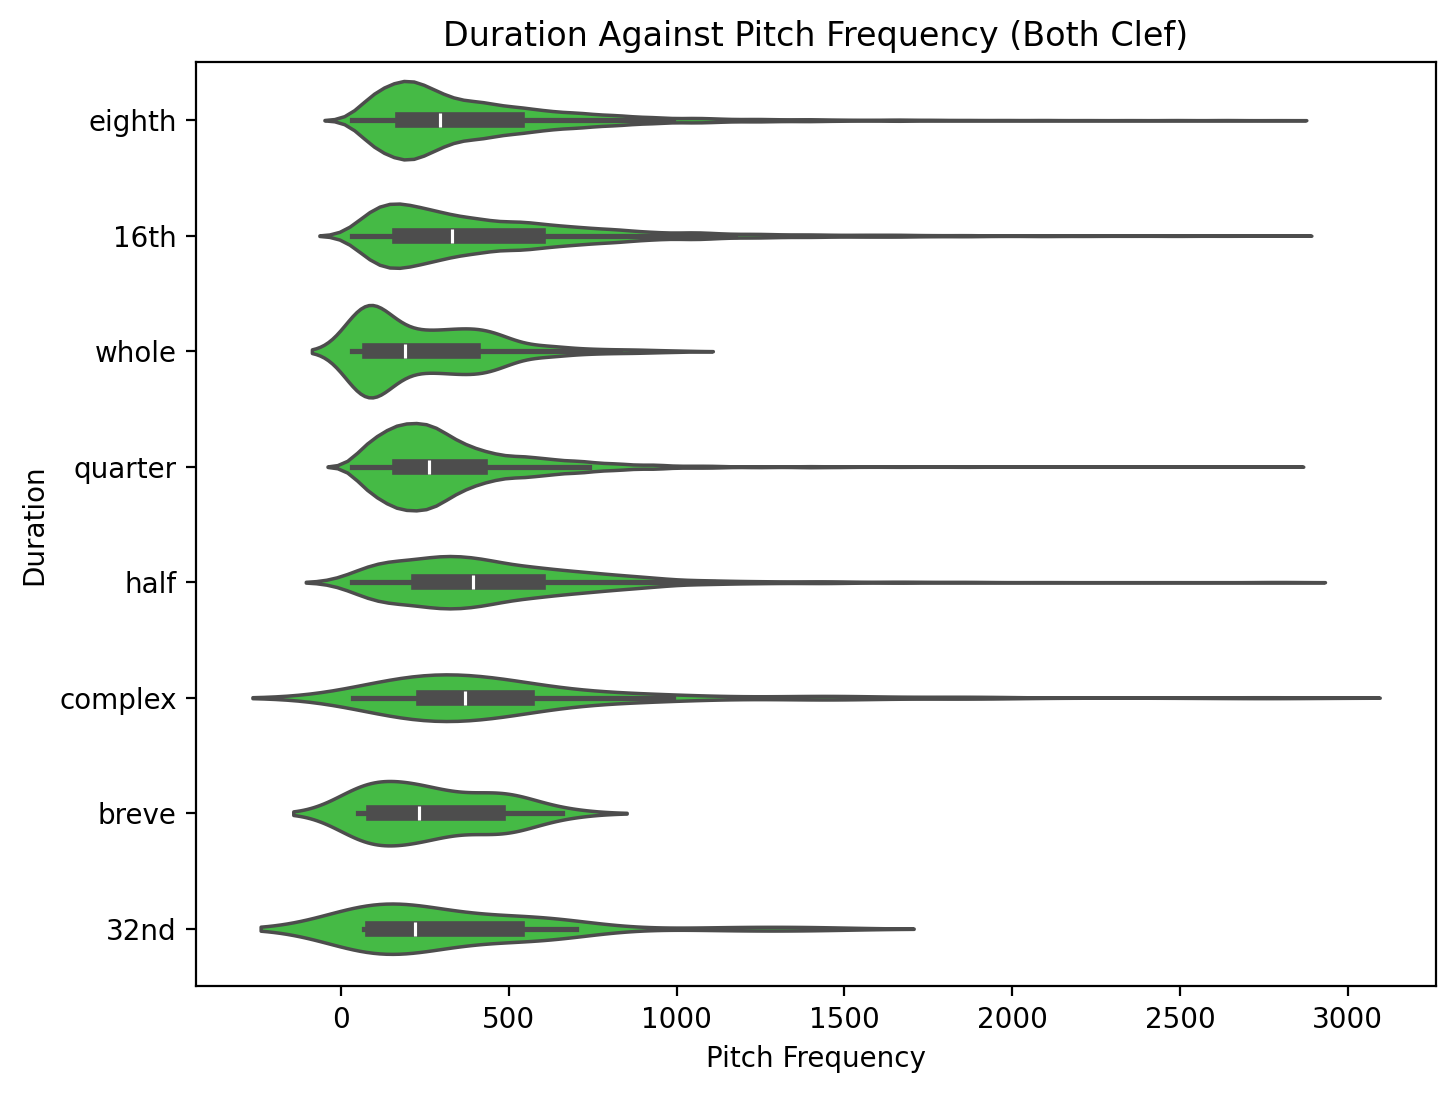

In [ ]:
plt.figure(figsize=(8, 6))
sns.violinplot(x ='music_element', y ='duration', data = df,  color = "limegreen")
plt.xlabel('Pitch Frequency')
plt.ylabel('Duration')
plt.title("Duration Against Pitch Frequency (Both Clef)")
plt.show()

The 8th note and 16th note have almost similar shape of distribution which is positively skewed with similar range where most notes are in the range of 30 to 2800 hertz and mode of 200 hertz with majority of the notes lies in the range of 100 to 1000 hertz. Half note has similar distribution range but the distribution is symmetric. The quarter note distribution has notable mode around 250 hertz with the range of 0 to 1200 hertz with majority of the notes lies in the range of 100 to 500 hertz. The whole note distribution is positively skewed with the mode around 150 hertz with distribution range of 0 to 1100 hertz with the majority of notes lies in the range of 50 to 500 hertz. The complex note has the longest range of distribution of 0 to 3000 hertz. Both breve note and 32nd note, both are positively skewed but different shape and range. The range of distribtion of 32nd note is a bit longer compared to the range of distribtion of breve note while both have almost the same mode around 200 hertz.

# Outlier Analysis

## Bass Clef

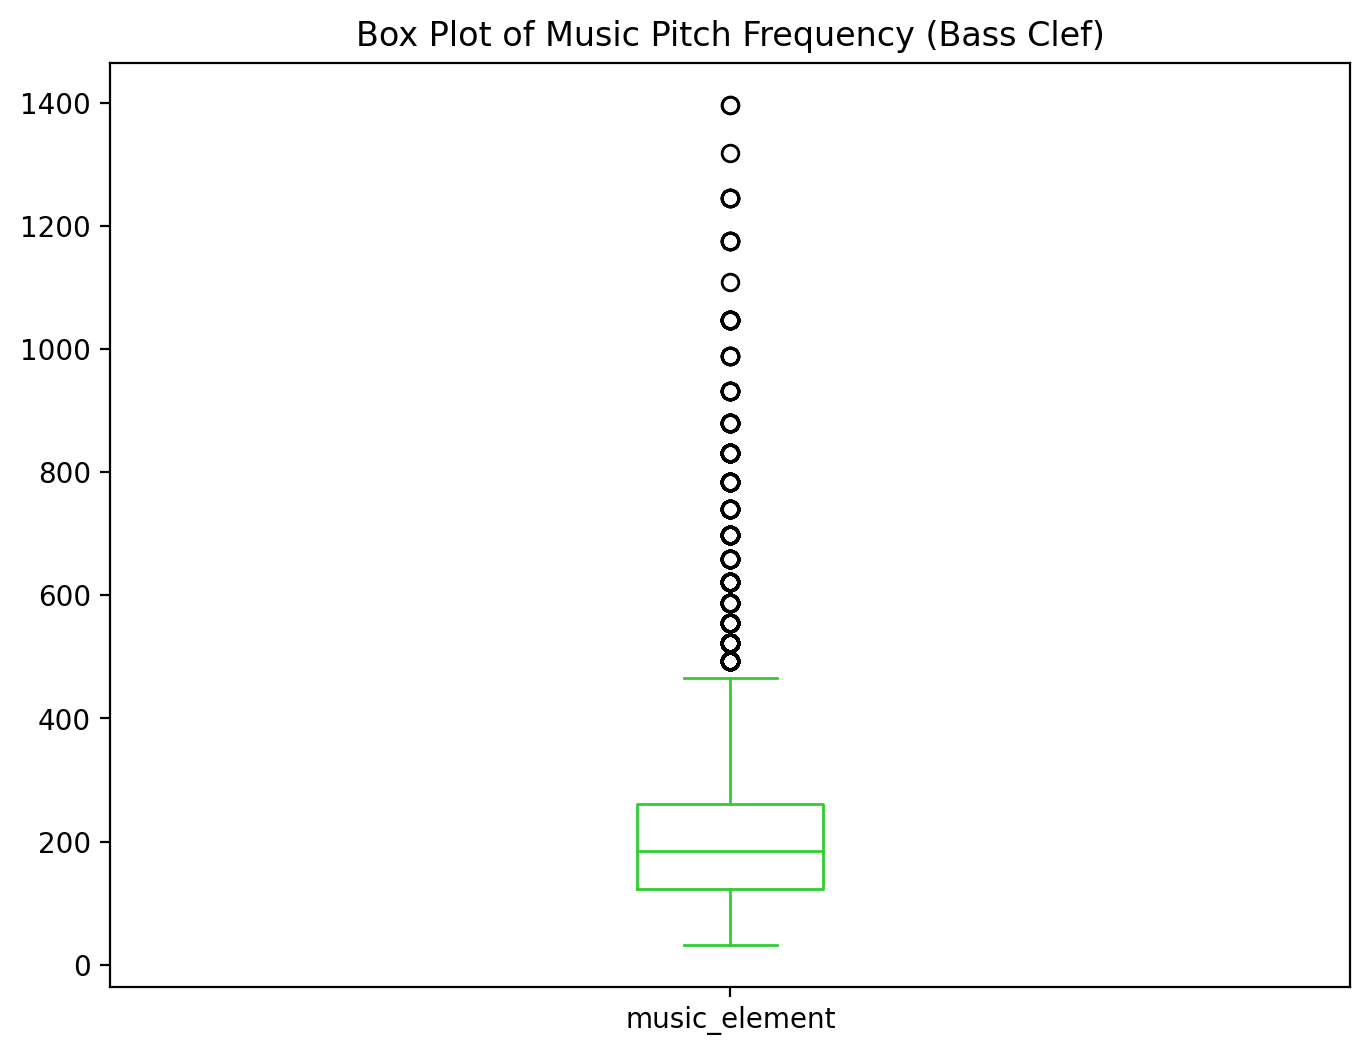

In [ ]:
bass_df.plot(kind='box', subplots=True, figsize=(8,6),  color = "limegreen")
plt.title("Box Plot of Music Pitch Frequency (Bass Clef)")
plt.show()

From the plot, the median of the bass clef distribution is at 200 hertz with the interquartile range of 150 to 250 hertz. The bass clef distribution has maximum of around 500 hertz and minimum of around 50 hertz. The notes above 500 hertz are identfied as outliers.

## Treble Clef

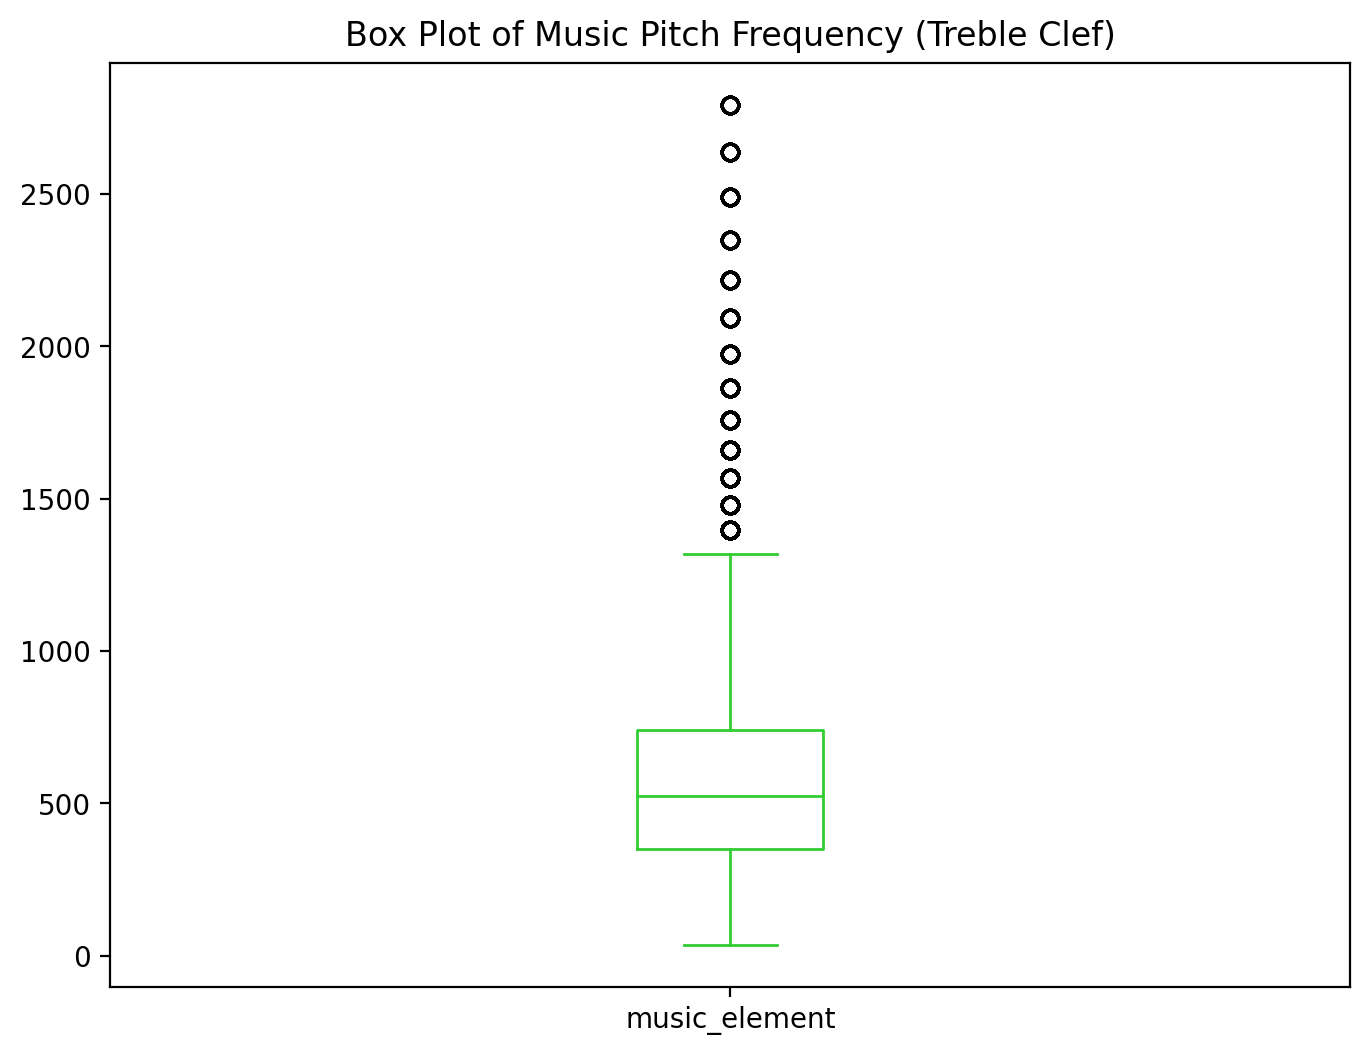

In [ ]:
treble_df.plot(kind='box', subplots=True, figsize=(8,6),  color = "limegreen")
plt.title("Box Plot of Music Pitch Frequency (Treble Clef)")
plt.show()

From the plot, the median of the treble clef distribution is at 500 hertz with the interquartile range of 400 to 750 hertz. The bass clef distribution has maximum of around 1300 hertz and minimum of around 50 hertz. The notes above 1300 hertz are identfied as outliers.

## Both Clef

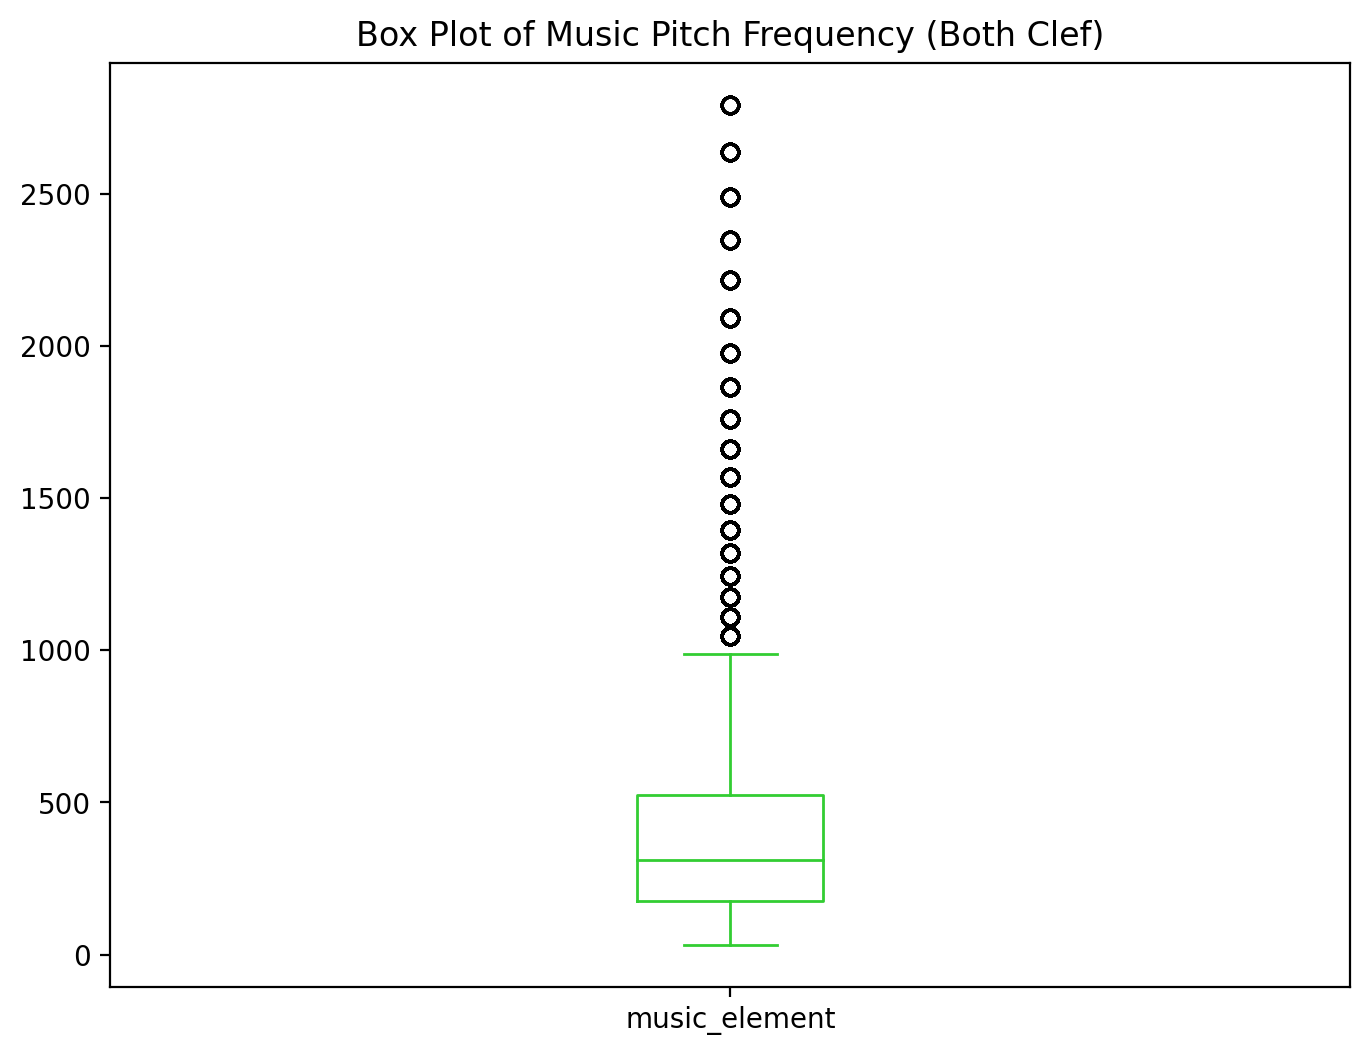

In [ ]:
df.plot(kind='box', subplots=True, figsize=(8,6), color = "limegreen")
plt.title("Box Plot of Music Pitch Frequency (Both Clef)")
plt.show()

From the plot, the median of the both clef distribution is at 300 hertz with the interquartile range of around 150 to 500 hertz. The both clef distribution has maximum of around 1000 hertz and minimum of around 50 hertz. The notes above 1000 hertz are identfied as outliers.

The outliers analsis shows there are many outliers in the data. However, the technique used to deal with outliers is simply keep the outliers in the data. Dealing with outliers by removing will affect the sequences of the notes which make the music have high degree of disorderness in the notes sequences which may cause worst output of AI-generate music.